In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

### Read data from parquet 

In [27]:
def read_dataframe(filename: str) -> pd.DataFrame:
    # Load data based on file extension
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)
    else:
        raise ValueError("Unsupported file format. Use .csv or .parquet")

    # Convert datetime columns
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

    # Compute trip duration in minutes
    df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']) / pd.Timedelta(minutes=1)

    # Filter out trips with duration outside 1–60 minutes
    df = df.loc[df['duration'].between(1, 60)].copy()

    # Cast categorical columns to string
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df


## Q1. Downloading the data
We'll use the same NYC taxi dataset, but instead of "Green Taxi Trip Records", we'll use "Yellow Taxi Trip Records".  

Download the data for January and February 2023.  

Read the data for January. How many columns are there?  

16  
17  
18  
**19**

In [5]:
df = pd.read_parquet('../data/yellow_tripdata_2023-01.parquet')
df.shape

(3066766, 19)

## Q2. Computing duration
Now let's compute the duration variable. It should contain the duration of a ride in minutes.  

What's the standard deviation of the trips duration in January?  

32.59  
**42.59**
52.59  
62.59  

In [8]:
df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']) / pd.Timedelta(minutes=1)
df['duration'].describe()

count    3.066766e+06
mean     1.566900e+01
std      4.259435e+01
min     -2.920000e+01
25%      7.116667e+00
50%      1.151667e+01
75%      1.830000e+01
max      1.002918e+04
Name: duration, dtype: float64

## Q3. Dropping outliers

Next, we need to check the distribution of the `duration` variable. There are some outliers. Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

What fraction of the records left after you dropped the outliers?

* 90%
* 92%
* 95%  
* **98%**

<Axes: >

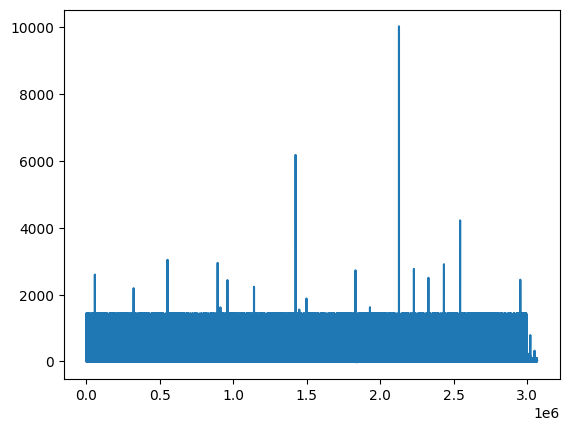

In [13]:
df['duration'].plot()

In [15]:
df_rows = df.shape[0]
df_rows

3066766

In [16]:
# Filter out trips with duration outside 1–60 minutes
df = df.loc[df['duration'].between(1, 60)].copy()
(df.shape[0] / df_rows)*100

98.1220282212598

## Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model. 

* Turn the dataframe into a list of dictionaries (remember to re-cast the ids to strings - otherwise it will 
  label encode them)
* Fit a dictionary vectorizer 
* Get a feature matrix from it

What's the dimensionality of this matrix (number of columns)?

* 2
* 155
* 345
* **515**
* 715

In [18]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333


In [20]:
categorical = ['PULocationID' , 'DOLocationID']

df[categorical] = df[categorical].astype(str)
dv = DictVectorizer()

train_dicts = df[categorical].to_dict(orient='records')
x_train = dv.fit_transform(train_dicts)
x_train.shape

(3009173, 515)

## Q5. Training a model

Now let's use the feature matrix from the previous step to train a model. 

* Train a plain linear regression model with default parameters, where duration is the response variable
* Calculate the RMSE of the model on the training data

What's the RMSE on train?

* 3.64
* **7.64**
* 11.64
* 16.64



In [25]:
target = 'duration'
y_train = df[target].values

In [26]:
lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred = lr.predict(x_train)

root_mean_squared_error(y_train, y_pred)

7.6492624397080675

## Q6. Evaluating the model

Now let's apply this model to the validation dataset (February 2023). 

What's the RMSE on validation?

* 3.81
* **7.81**
* 11.81
* 16.81


In [29]:
df_test = read_dataframe('../data/yellow_tripdata_2023-02.parquet') 

In [30]:
val_dicts = df_test[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [31]:
y_val = df_test[target].values

In [32]:
lr = LinearRegression()
lr.fit(x_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.81181211389241

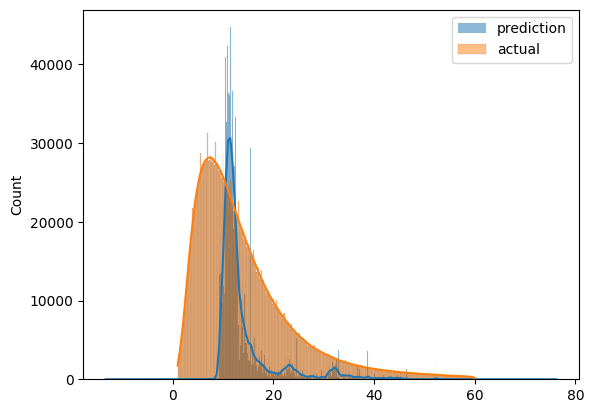

In [33]:
sns.histplot(y_pred, label='prediction', kde=True)
sns.histplot(y_train, label='actual',kde=True)

plt.legend()